# NYC PLUTO Data and Noise Complaints

Investigating how PLUTO data and zoning characteristics impact spatial, temporal and types of noise complaints through out New York City. Specifically looking at noise complaints that are handled by NYC's Department of Environmental Protection (DEP).

All work performed by Zoe Martiniak.

In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import urllib
import requests
from sodapy import Socrata
import matplotlib
import matplotlib.pyplot as plt
import pylab as pl
from pandas.plotting import scatter_matrix
%matplotlib inline
%pylab inline

##Geospatial
import shapely
import geopandas as gp
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
from shapely.geometry import Point, MultiPoint
import io
from geopandas.tools import sjoin
from shapely.ops import nearest_points

## Statistical Modelling
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.datasets.longley import load
import sklearn.preprocessing as preprocessing
from sklearn.ensemble  import RandomForestRegressor as rfr
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix


from APPTOKEN import myToken
## Save your SOTA API Token as variable myToken in a file titled SOTAPY_APPTOKEN.py
## e.g.
## myToken = 'XXXXXXXXXXXXXXXX'

Populating the interactive namespace from numpy and matplotlib


/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# DATA IMPORTING

Applying domain knowledge to only read in columns of interest to reduce computing requirements.

### PLUTO csv file

In [29]:
pluto = pd.read_csv(os.getenv('MYDATA')+'/pluto_18v2.csv', usecols=['borocode','zonedist1', 
        'overlay1',  'bldgclass', 'landuse',
       'ownertype','lotarea', 'bldgarea', 'comarea',
       'resarea', 'officearea', 'retailarea', 'garagearea', 'strgearea',
       'factryarea', 'otherarea', 'numfloors',
       'unitsres', 'unitstotal', 'proxcode', 'lottype','lotfront', 
    'lotdepth', 'bldgfront', 'bldgdepth',
       'yearalter1',  
       'assessland', 'yearbuilt','histdist', 'landmark', 'builtfar',
       'residfar', 'commfar', 'facilfar','bbl', 'xcoord','ycoord'])


### 2010 Census Blocks

In [3]:
census = gp.read_file('Data/2010 Census Blocks/geo_export_56edaf68-bbe6-44a7-bd7c-81a898fb6f2e.shp')

### Read in 311 Complaints

In [4]:
complaints = pd.read_csv('Data/311DEPcomplaints.csv', usecols=['address_type','borough','city',
       'closed_date', 'community_board','created_date',
       'cross_street_1', 'cross_street_2', 'descriptor', 'due_date',
       'facility_type', 'incident_address', 'incident_zip',
       'intersection_street_1', 'intersection_street_2', 'latitude',
       'location_type', 'longitude', 'resolution_action_updated_date',
       'resolution_description', 'status', 'street_name' ])


/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (12,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
## Many missing lat/lon values in complaints file
## Is it worth it to manually fill in NaN with geopy geocded laton/long?
len(complaints[(complaints.latitude.isna()) | (complaints.longitude.isna())])/len(complaints)


0.016172093937579145

### Mannually Filling in Missing Lat/Long from Addresses

Very time and computationally expensive, so this step should be performed on a different machine.
For our intents and purposes, I will just be dropping rows with missing lat/long

In [6]:
complaints.dropna(subset=['longitude', 'latitude'],inplace=True)
complaints['createdate'] = pd.to_datetime(complaints['created_date'])
complaints = complaints[complaints.createdate >= datetime.datetime(2018,1,1)]
complaints = complaints[complaints.createdate < datetime.datetime(2019,1,1)]
complaints['lonlat']=list(zip(complaints.longitude.astype(float), complaints.latitude.astype(float)))
complaints['geometry']=complaints[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
crs = {'init':'epsg:4326', 'no_defs': True}
complaints = gp.GeoDataFrame(complaints, crs=crs, geometry=complaints['geometry'])

## NYC Zoning Shapefile

In [7]:
zoning = gp.GeoDataFrame.from_file('Data/nycgiszoningfeatures_201902shp/nyzd.shp')
zoning.to_crs(epsg=4326, inplace=True)

# PLUTO Shapefiles

## Load in PLUTO Shapefiles by Boro
The PLUTO shapefiles are incredibly large. I used ArcMAP to separate the pluto shapefiles by borough and saved them locally. 
My original plan was to perform a spatial join of the complaints to the pluto shapefiles to find the relationship between PLUTO data on the building-scale and noise complaints.
While going through this exploratory analysis, I discovered that the 311 complaints are actually all located in the street and therefore the points do not intersect with the PLUTO shapefiles. This brings up some interesting questions, such as how the lat/long coordinates are assigned by the DEP.

I am including this step to showcase that the complaints do not intersect with the shapefiles, to justify my next step of simply aggregating by zoning type with the zoning shapefiles. 

In [8]:
## PLUTO SHAPEFILES BY BORO
#files = ! ls Data/PLUTO_Split | grep '.shp'
boros= ['bronx','brooklyn','man','queens','staten']
columns_to_drop = ['FID_pluto_', 'Borough','CT2010', 'CB2010',
       'SchoolDist', 'Council', 'FireComp', 'PolicePrct',
       'HealthCent', 'HealthArea', 'Sanitboro', 'SanitDistr', 'SanitSub',
       'Address','BldgArea', 'ComArea', 'ResArea', 'OfficeArea',
       'RetailArea', 'GarageArea', 'StrgeArea', 'FactryArea', 'OtherArea',
       'AreaSource','LotFront', 'LotDepth', 'BldgFront', 'BldgDepth', 'Ext', 'ProxCode',
       'IrrLotCode', 'BsmtCode', 'AssessLand', 'AssessTot',
       'ExemptLand', 'ExemptTot','ResidFAR', 'CommFAR', 'FacilFAR',
       'BoroCode','CondoNo','XCoord', 'YCoord', 'ZMCode', 'Sanborn', 'TaxMap', 'EDesigNum', 'APPBBL',
       'APPDate', 'PLUTOMapID', 'FIRM07_FLA', 'PFIRM15_FL', 'Version','BoroCode_1', 'BoroName']


bx_shp = gp.GeoDataFrame.from_file('Data/PLUTO_Split/Pluto_bronx.shp')
bx_311 = complaints[complaints.borough == 'BRONX']
bx_shp.to_crs(epsg=4326, inplace=True)
bx_shp.drop(columns_to_drop, axis=1, inplace=True)

## Mapping

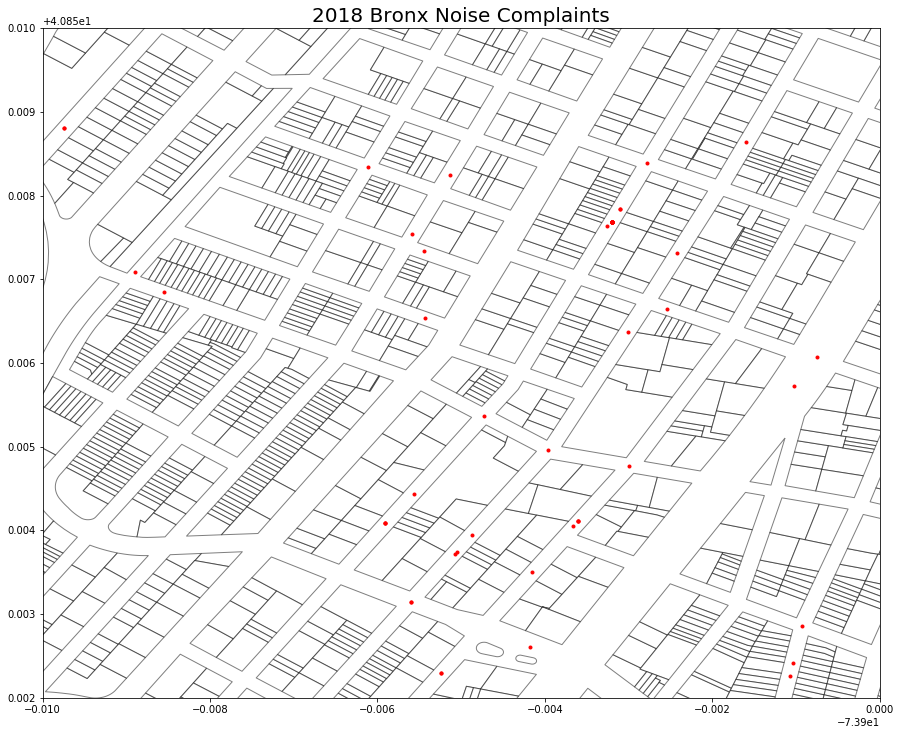

In [9]:
f, ax = plt.subplots(figsize=(15,15))
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
ax.set_xlim(-73.91, -73.9)
ax.set_ylim(40.852, 40.86)
bx_shp.plot(ax=ax, color = 'w', edgecolor='k',alpha=0.5, legend=True)
plt.title("2018 Bronx Noise Complaints", size=20)
bx_311.plot(ax=ax,marker='.', color='red')#, markersize=.4, alpha=.4)
#fname = 'Bronx2018zoomed.png'
#plt.savefig(fname)
plt.show()

**Fig1:** This figure shows that the complaint points are located in the street, and therefore do not intersect with a tax lot. Therefore we cannot perform a spatial join on the two shapefiles.

# Data Cleaning & Simplifying

Here we apply our domain knowledge of zoning and Pluto data to do a bit of cleaning. This includes simplifying the zoning districts to extract the first letter, which can be one of the following five options:<br />
B: Ball Field, BPC<br />
P: Public Place, Park, Playground (all public areas)<br />
C: Commercial<br />
R: Residential<br />
M: Manufacturing<br />

In [10]:
print(len(zoning.ZONEDIST.unique()))
print(len(pluto.zonedist1.unique()))

166
163


In [11]:
def simplifying_zone(x):
    if x in ['PLAYGROUND','PARK','PUBLIC PLACE','BALL FIELD' ,'BPC']:
        return 'P'
    if '/' in x:
        return 'O'
    if x[:3] == 'R10':
        return x[:3]
    else:
        return x[:2]

In [12]:
def condensed_simple(x):
    if x[:2] in ['R1','R2', 'R3','R4']:
        return 'R1-R4'
    if x[:2] in ['R5','R6', 'R7']:
        return 'R5-R7'
    if x[:2] in ['R8','R9', 'R10']:
        return 'R8-R10'
    if x[:2] in ['C1','C2']:
        return 'C1-C2'
    if x[:2] in ['C5','C6']:
        return 'C5-C6'
    if x[:2] in ['C3','C4','C7','C8']:
        return 'C'
    if x[:1] =='M':
        return 'M'
    else:
        return x[:2]

In [30]:
cols_to_tidy = []
notcommon = []
for c in pluto.columns:
    if type(pluto[c].mode()[0]) == str:
        cols_to_tidy.append(c)

In [31]:
for c in cols_to_tidy:              
    pluto[c].fillna('U',inplace=True)
pluto.fillna(0,inplace=True)

In [32]:
pluto['bldgclass'] = pluto['bldgclass'].map(lambda x: x[0])
pluto['overlay1'] = pluto['overlay1'].map(lambda x: x[:2])
pluto['simple_zone'] = pluto['zonedist1'].map(simplifying_zone)
pluto['condensed'] = pluto['simple_zone'].map(condensed_simple)

In [16]:
zoning_analysis = pluto[['lotarea', 'bldgarea', 'comarea',
       'resarea', 'officearea', 'retailarea', 'garagearea', 'strgearea',
       'factryarea', 'otherarea', 'areasource', 'numbldgs', 'numfloors',
       'unitsres', 'unitstotal', 'lotfront', 'lotdepth', 'bldgfront',
       'bldgdepth','lotfront', 'lotdepth', 'bldgfront',
       'bldgdepth','yearbuilt',
       'yearalter1', 'yearalter2','builtfar','simple_zone']]

In [17]:
zoning_analysis.dropna(inplace=True)

/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
## Cleaning the Complaint file for easier 1-hot-encoding

def TOD_shifts(x):
    if x.hour <=7:
        return 'M'
    if x.hour  >7 and x.hour<18:
        return 'D'
    if x.hour  >= 18: 
        return 'E'

def DOW_(x):
    weekdays = ['mon','tues','weds','thurs','fri','sat','sun']
    for i in range(7):
        if x.dayofweek == i:
            return weekdays[i]

def resolution_(x):
    descriptions = complaints.resolution_description.unique()
    for a in [2,3,4,5,11,12,14,17,20,23,25]:
        if x == descriptions[a]:
            return 'valid_no_vio'
            continue
        next
    if x == descriptions[1]:
        return 'violation'
        next
    for b in [0,6,10,16,19,21,24]:
        if x == descriptions[b]:
            return 'further_investigation'
            continue
        next
    for c in [7,8,9,13,15,18,22]:
        if x == descriptions[c]:
            return 'access_issue'
        

#### SIMPLIFIED COMPLAINT DESCRIPTIONS
0: Did not observe violation<br/>
1: Violation issued <br/>
No violation issued yet/canceled/resolved because:<br/>
2: Duplicate<br/>
3: Not warranted<br/>
4: Complainant canceled<br/>
5: Not warranted<br/>
6: Investigate further<br/>
7: Closed becuase complainant didnt respond<br/>
8: Incorrect complainant contact info (phone)<br/>
9: Incorrect complainant contact info (address)<br/>
10: Further investigation<br/>
11: NaN<br/>
12: Status unavailable<br/>
13: Could not gain access to location<br/>
14: NYPD<br/>
15: Sent letter to complainant after calling<br/>
16: Recieved letter from dog owner<br/>
17: Resolved with complainant<br/>
18: Incorrect address<br/>
19: An inspection is warranted<br/>
20: Hydrant<br/>
21: 2nd inspection<br/>
22: No complainant info<br/>
23: Refer to other agency (not nypd)<br/>
24: Inspection is scheduled<br/>
25: Call 311 for more info<br/>

Violation: [1]
not warranted/canceled/otheragency/duplicate: [2,3,4,5,11,12,14,17,20,23,25]
Complainant/access issue: [7,8,9,13,15,18,22]
Further investigtion: [0,6,10,16,19,21,24]

In [19]:
complaints['TOD']=complaints.createdate.map(TOD_shifts)
complaints['DOW']=complaints.createdate.map(DOW_)

## PLUTO/Zoning Feature Analysis

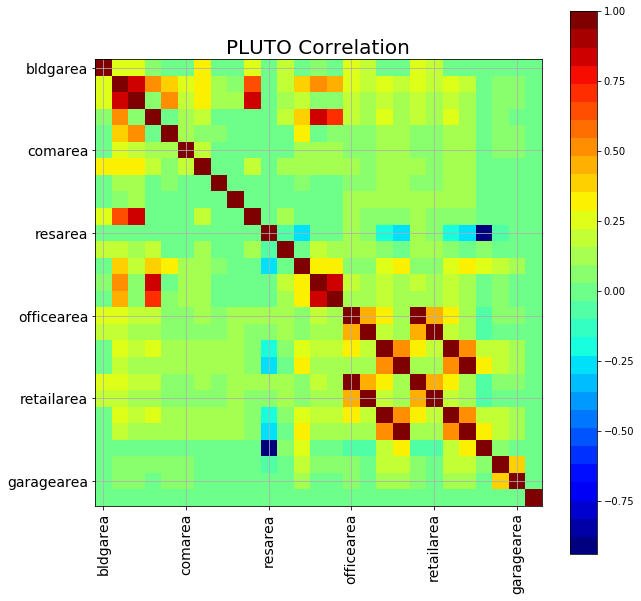

In [20]:
## Obtained this line of code from datascience.stackexchange @ the following link:
## https://datascience.stackexchange.com/questions/10459/calculation-and-visualization-of-correlation-matrix-with-pandas
def drange(start, stop, step):
    r = start
    while r <= stop:
        yield r
        r += step
        
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('PLUTO Correlation', size=20)
    labels =[x for x in zoning_analysis.columns ] 
    ax1.set_yticklabels(labels,fontsize=14)
    ax1.set_xticklabels(labels,fontsize=14, rotation='90')

    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks = list(drange(-1, 1, 0.25)))
    plt.show()

correlation_matrix(zoning_analysis)


/Users/zoemartiniak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


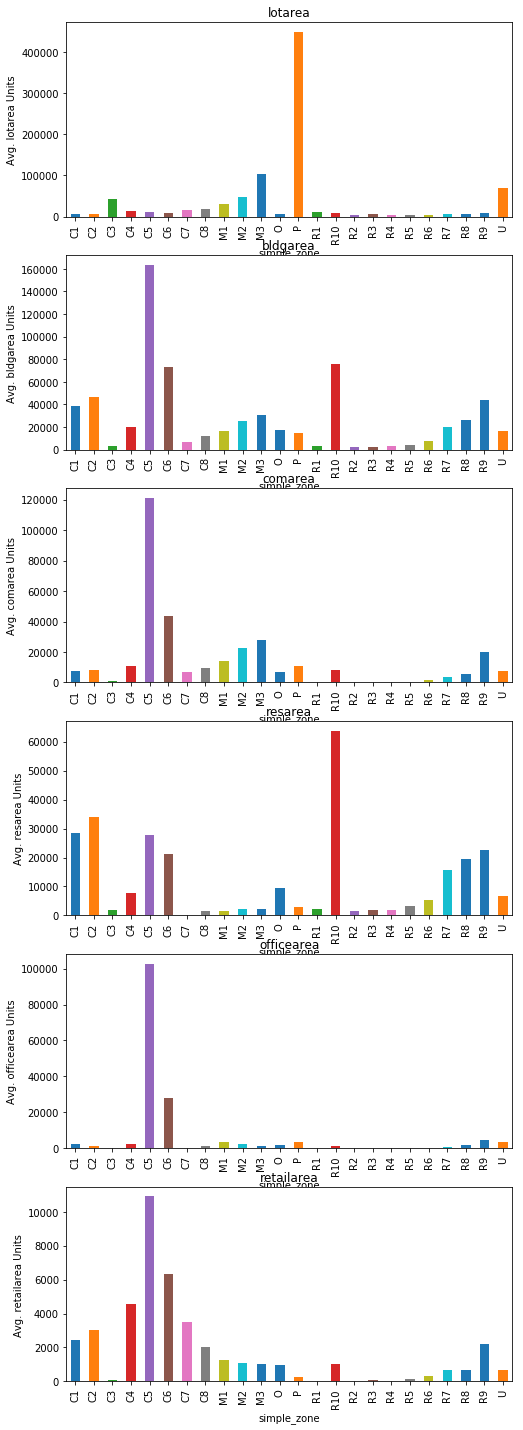

In [21]:
zoning_analysis.sort_values(['simple_zone'],ascending=False, inplace=True)
y = zoning_analysis.groupby('simple_zone').mean()
f, axes = plt.subplots(figsize=(8,25), nrows=6, ncols=1)
cols = ['lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea']
for colind in range(6):
    y[cols[colind]].plot(ax = plt.subplot(6,1,colind+1), kind='bar')
    plt.ylabel('Avg. {} Units'.format(cols[colind]))
    plt.title(cols[colind])
    
    

In [22]:
zoning['simple_zone'] = zoning['ZONEDIST'].map(simplifying_zone)
zoning['condensed'] = zoning['simple_zone'].map(condensed_simple)

In [23]:
zoning = zoning.reset_index().rename(columns={'index':'zdid'})

## Perform Spatial Joins

In [24]:
## Joining Census group shapefile to PLUTO shapefile

sjoin(census, plutoshp)

NameError: name 'plutoshp' is not defined

In [ ]:
## Joining the zoning shapefile to complaints
zoning_joined = sjoin(zoning, complaints).reset_index()
zoning_joined.drop('index',axis=1, inplace=True)
print(zoning.shape)
print(complaints.shape)
print(zoning_joined.shape)

In [ ]:
zoning_joined.drop(columns=['index_right', 'address_type', 'borough',
       'city', 'closed_date', 'community_board', 'created_date',
       'cross_street_1', 'cross_street_2', 'due_date',
       'facility_type', 'incident_address', 'incident_zip',
       'intersection_street_1', 'intersection_street_2', 
       'location_type',  'resolution_action_updated_date',
       'resolution_description', 'status', 'street_name', 'lonlat'], inplace=True)

In [ ]:
## Joining each borough PLUTO shapefile to zoning shapefile
bx_shp['centroid_colum'] = bx_shp.centroid
bx_shp = bx_shp.set_geometry('centroid_colum')
pluto_bx = sjoin(zoning, bx_shp).reset_index()

In [ ]:
print(zoning.shape)
print(bx_shp.shape)
print(pluto_bx.shape)

In [ ]:
pluto_bx = pluto_bx.groupby('zdid')['LandUse', 'LotArea', 'NumBldgs', 'NumFloors', 'UnitsRes',
       'UnitsTotal', 'LotType', 'YearBuilt','YearAlter1', 'YearAlter2','BuiltFAR'].mean()

In [ ]:
pluto_bx = zoning.merge(pluto_bx, on='zdid')

# ANALYSIS

## Visual Analysis

In [ ]:
x = zoning_joined.groupby('simple_zone')['ZONEDIST'].count().index
y = zoning_joined.groupby('simple_zone')['ZONEDIST'].count()

f, ax = plt.subplots(figsize=(12,9))
plt.bar(x, y)
plt.ylabel('Counts', size=12)
plt.title('Noise Complaints by Zoning Districts (2018)', size=15)

**FIg 1** This shows the total counts of complaints by Zoning district. Clearly there are more complaints in middle/high-population density residential zoning districts. There are also high complaints in commercial districts C5 & C6. These commercial districts tend to have a residential overlay.

In [ ]:
y.sort_values(ascending=False, inplace=True)
x = y.index
descriptors = zoning_joined.descriptor.unique()

df = pd.DataFrame(index=x)


for d in descriptors:
    df[d] = zoning_joined[zoning_joined.descriptor == d].groupby('simple_zone')['ZONEDIST'].count()

df = df.div(df.sum(axis=1), axis=0)
ax = df.plot(kind="bar", stacked=True, figsize=(18,12))
df.sum(axis=1).plot(ax=ax, color="k")
plt.title('Noise Complaints by Descriptor', size=20)
plt.xlabel('Simplified Zone District (Decreasing Total Count -->)', size=12)
plt.ylabel('%', size=12)
fname = 'Descriptorpercent.jpeg'
#plt.savefig(fname)
plt.show()

**FIg 2** This figure shows the breakdown of the main noise complaint types per zoning district.

In [ ]:
descriptors

In [ ]:
complaints_by_zone = pd.get_dummies(zoning_joined, columns=['TOD','DOW'])
complaints_by_zone = complaints_by_zone.rename(columns={'TOD_D':'Day','TOD_E':'Night',
    'TOD_M':'Morning','DOW_fri':'Friday','DOW_mon':'Monday','DOW_sat':'Saturday',
    'DOW_sun':'Sunday','DOW_thurs':'Thursday','DOW_tues':'Tuesday','DOW_weds':'Wednesday'})
complaints_by_zone.drop(columns=['descriptor', 'latitude', 'longitude','createdate'],inplace=True)

In [ ]:
complaints_by_zone = complaints_by_zone.groupby('zdid').sum()[['Day', 'Night', 'Morning', 'Friday',
       'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']].reset_index()


In [ ]:
## Creating total counts of complaints by zoning district
complaints_by_zone['Count_TOD'] = (complaints_by_zone.Day + 
                            complaints_by_zone.Night + 
                                complaints_by_zone.Morning)
complaints_by_zone['Count_DOW'] = (complaints_by_zone.Monday + 
                            complaints_by_zone.Tuesday + 
                                complaints_by_zone.Wednesday +
                                 complaints_by_zone.Thursday + 
                            complaints_by_zone.Friday + 
                                complaints_by_zone.Saturday + 
                                  complaints_by_zone.Sunday)

## Verifying the counts are the same
complaints_by_zone[complaints_by_zone.Count_TOD != complaints_by_zone.Count_DOW]


In [ ]:
print(complaints_by_zone.shape)
print(zoning.shape)

complaints_by_zone = zoning.merge(complaints_by_zone, on='zdid')
print(complaints_by_zone.shape)

In [ ]:
f, ax = plt.subplots(1,figsize=(13,13))
ax.set_axis_off()
ax.set_title('Avg # of Complaints',size=15)
complaints_by_zone.plot(ax=ax, column='Count_TOD', cmap='gist_earth', k=3, alpha=0.7, legend=True)
fname = 'AvgComplaintsbyZD.png'
plt.savefig(fname)
plt.show()

In [ ]:
complaints_by_zone['Norm_count'] = complaints_by_zone.Count_TOD/complaints_by_zone.Shape_Area*1000000
f, ax = plt.subplots(1,figsize=(13,13))
ax.set_axis_off()
ax.set_title('Complaints Normalized by ZD Area',size=15)
complaints_by_zone[complaints_by_zone.Norm_count < 400].plot(ax=ax, column='Norm_count', cmap='gist_earth', k=3, alpha=0.7, legend=True)
fname = 'NormComplaintsbyZD.png'
plt.savefig(fname)
plt.show()



**Fig 3** This figure shows the spread of noise complaint density (complaints per unit area) of each zoning district.

In [ ]:
complaints_by_zone.columns

In [ ]:
TODcols = ['Day', 'Night', 'Morning']
fig = pl.figure(figsize=(30,20))

for x in range(1,8):
    
    fig.add_subplot(2,3,x).set_axis_off()
    fig.add_subplot(2,3,x).set_title(title[x-1], size=28)
    pumashp.plot(column=column[x-1],cmap='Blues', alpha=1, 
                 edgecolor='k', ax=fig.add_subplot(2,3,x), legend=True)
    

In [ ]:
DOWcols = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
fig = pl.figure(figsize=(30,20))
for x in range(1,7):
    
    fig.add_subplot(2,3,x).set_axis_off()
    fig.add_subplot(2,3,x).set_title(DOWcols[x-1], size=28)
    complaints_by_zone.plot(column=DOWcols[x-1],cmap='gist_stern', alpha=1, 
                 ax=fig.add_subplot(2,3,x), legend=True)
    


## Regression

Define lat/long coordinates of zoning centroids for regression

In [ ]:
complaints_by_zone.shape

In [ ]:
complaints_by_zone['centerlong'] = complaints_by_zone.centroid.x
complaints_by_zone['centerlat'] = complaints_by_zone.centroid.y


In [ ]:
mod = smf.ols(formula = 
    'Norm_count ~ centerlat + centerlong', data=complaints_by_zone)
results1 = mod.fit()
results1.summary()

In [ ]:
len(complaints_by_zone.ZONEDIST.unique())

In [ ]:
mod = smf.ols(formula = 
    'Norm_count ~ ZONEDIST', data=complaints_by_zone)
results1 = mod.fit()
results1.summary()

In [ ]:
len(complaints_by_zone.simple_zone.unique())

In [ ]:
mod = smf.ols(formula = 
    'Norm_count ~ simple_zone', data=complaints_by_zone)
results1 = mod.fit()
results1.summary()

In [ ]:
complaints_by_zone.condensed.unique()

In [ ]:
mod = smf.ols(formula = 
    'Norm_count ~ condensed', data=complaints_by_zone)
results1 = mod.fit()
results1.summary()

### PLAN 
- JOIN ALL ZONE DIST TO PLUTO SHAPEFILES, AGGREGATE FEATURES
- PERFORM REGRESSION

COMPLEX CLASSIFIERS
- DECISION TREE AND CLUSTERING 

In [ ]:
import folium
from folium.plugins import HeatMap

In [ ]:
hmap = folium.Map()
hm_wide = HeatMap( list(zip()))




In [ ]:
f, ax = plt.subplots(figsize=(15,15))
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
zoning.plot(column='counts',ax=ax, cmap='plasma', alpha = 0.9, legend=True)
plt.title("Complaints by Zone", size=20)
